In [ ]:
!pip install dask[dataframe] --upgrade

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
import xml.etree.ElementTree as et
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import time, datetime

Set pathes for ``Export.xml`` and ``df.csv``.





In [3]:
export_xml_file_path = '/content/drive/My Drive/explore_ios_health/apple_health_export/Export.xml'
apple_health_csv_file_path = '/content/drive/My Drive/explore_ios_health/apple_health_export/df.csv'

In [4]:
xtree = et.parse(export_xml_file_path)
xroot = xtree.getroot()

In [6]:
def rows_columns():
  
  types = set([])
  rows = []
    
  for node in xroot[0:]: 

    types.add(node.attrib.get('type'))
    
    if node.attrib.get('type') == 'HKQuantityTypeIdentifierHeartRate' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierActiveEnergyBurned' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierDistanceWalkingRunning' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierAppleExerciseTime' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierAppleStandTime' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierStepCount':    

        s_type = node.attrib.get('type')
        s_unit = node.get('unit')
        s_date = node.get('startDate')
        s_value = float(node.get('value'))
        s_source = node.get('sourceName')

        columns = ['type','source', 'unit', 'dateTime', 'value']
        
        rows.append({'type': s_type, 
                     'unit': s_unit, 
                     'dateTime': s_date,
                     'source': s_source, 
                     'value': s_value})


  print('Available data types:')
  for data_type in types:
    print(data_type) 
  return (rows, columns) 

In [7]:
rows, columns = rows_columns()
df = pd.DataFrame(rows, columns=columns)
df = df.dropna()

print(f'\nShape:{df.shape}')
df.head()

Available data types:
HKQuantityTypeIdentifierBodyMassIndex
HKQuantityTypeIdentifierStairDescentSpeed
HKQuantityTypeIdentifierBasalEnergyBurned
HKQuantityTypeIdentifierVO2Max
HKQuantityTypeIdentifierWalkingStepLength
HKQuantityTypeIdentifierStepCount
HKQuantityTypeIdentifierActiveEnergyBurned
HKQuantityTypeIdentifierHeadphoneAudioExposure
HKQuantityTypeIdentifierHeartRateVariabilitySDNN
HKQuantityTypeIdentifierHeight
HKQuantityTypeIdentifierBodyFatPercentage
HKCategoryTypeIdentifierHighHeartRateEvent
HKQuantityTypeIdentifierEnvironmentalAudioExposure
HKQuantityTypeIdentifierWalkingHeartRateAverage
HKQuantityTypeIdentifierRestingHeartRate
None
HKCategoryTypeIdentifierMindfulSession
HKQuantityTypeIdentifierSixMinuteWalkTestDistance
HKQuantityTypeIdentifierDietaryWater
HKQuantityTypeIdentifierFlightsClimbed
HKQuantityTypeIdentifierLeanBodyMass
HKQuantityTypeIdentifierDistanceWalkingRunning
HKCategoryTypeIdentifierAppleStandHour
HKQuantityTypeIdentifierBodyMass
HKCorrelationTypeIdentifierB

,type,source,unit,dateTime,value
0,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:04 +0100,64.0
1,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:05 +0100,64.0
2,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:06 +0100,63.0
3,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:07 +0100,64.0
4,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:08 +0100,64.0


Remove objects to free some space.

In [ ]:
del(rows)
del(columns)
del(xtree)
del(xroot)

Store data frame in CSV if needed.

In [8]:
df.to_csv(apple_health_csv_file_path, index=False)

Load data frame from CSV if needed.

In [9]:
df = pd.read_csv(apple_health_csv_file_path)

print(f'Shape:{df.shape}')
df.head()

Shape:(3311516, 5)


,type,source,unit,dateTime,value
0,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:04 +0100,64.0
1,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:05 +0100,64.0
2,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:06 +0100,63.0
3,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:07 +0100,64.0
4,HKQuantityTypeIdentifierHeartRate,Polar H7 319760,count/min,2014-09-28 18:18:08 +0100,64.0


Two different merge functions used for putting the final data frame together.

In [13]:
def merge_date_formated_df(df, data_type, column_name, grouped_strategy):
    
    # Get all rows from `data_type`
    grouped_df = df[df['type'].isin([data_type])]
    grouped_df = grouped_df.drop({'type','source','unit'}, axis=1)
    grouped_df = grouped_df.rename(columns={'value': column_name})

    # Floor `date_time` to minutes
    date_time = pd.to_datetime(grouped_df['dateTime'])
    date_time = date_time.dt.tz_localize(None)
    grouped_df['dateTime'] = date_time.dt.floor('min').copy()

    # Group by `date_time` and set value to mean or sum
    if grouped_strategy == 'Mean':
        grouped_df = round(grouped_df.groupby('dateTime', as_index=False).mean(), 0)
    elif grouped_strategy == 'Sum':
        grouped_df = round(grouped_df.groupby('dateTime', as_index=False).sum(), 4)
    else:
        raise ValueError(
            "Invalid value for 'grouped_strategy'! Should be either 'mean' or 'sum'.")
    
    # Create new `date` column
    date = pd.to_datetime(grouped_df['dateTime'])
    date = date.dt.tz_localize(None)
    grouped_df['date'] = date.dt.floor('d').copy()

    # Use new `date` column to create new columns containing the average or the sum
    if grouped_strategy == 'Mean':
      new_df = pd.DataFrame(grouped_df.groupby('date', as_index=False)[column_name].mean())
    elif grouped_strategy == 'Sum':
      new_df = pd.DataFrame(grouped_df.groupby('date', as_index=False)[column_name].sum())

    new_df = new_df.rename(columns={column_name: f'{column_name}{grouped_strategy}'})
    merged = pd.merge(grouped_df, new_df, on='date', how='outer')
    merged = merged.set_index('dateTime')
    return merged

def merge(dataframes_list):
    if len(dataframes_list) < 2:
        raise ValueError(
            "'dataframes_list' should contain at least two dataframes!")

    merged = dataframes_list[0].merge(dataframes_list[1], how='outer',
                      left_index=True, right_index=True)

    if len(dataframes_list) > 2:
        for df in dataframes_list[2:]:
            merged = merged.merge(df, how='outer',
                              left_index=True, right_index=True)
    return merged

Store data frames to CSV to handle them with desk.

In [14]:
merge_date_formated_df(
    df, 'HKQuantityTypeIdentifierHeartRate', 
    'heartRate(BPM)', 
    'Mean').to_csv("hr_temp.csv")

merge_date_formated_df(
    df, 
    'HKQuantityTypeIdentifierDistanceWalkingRunning', 
    'walkingRunningDistance(km)', 
    'Sum').to_csv('wd_temp.csv',index_label='dateTime')

merge_date_formated_df(
    df, 
    'HKQuantityTypeIdentifierActiveEnergyBurned', 
    'activeEnergyBurned(kal)', 
    'Sum').to_csv('aeb_temp.csv',index_label='dateTime')

merge_date_formated_df(
    df, 
    'HKQuantityTypeIdentifierAppleStandTime', 
    'standTime(min)', 
    'Sum').to_csv('st_temp.csv',index_label='dateTime')

merge_date_formated_df(
    df, 
    'HKQuantityTypeIdentifierStepCount', 
    'stepCount', 'Sum').to_csv('sc_temp.csv',index_label='dateTime')

Load data frames from using [Desk](https://dask.org/). This is needed so it can handle big data frame.

In [23]:
hr = dd.read_csv('hr_temp.csv').set_index('dateTime')
wd = dd.read_csv('wd_temp.csv').set_index('dateTime')
aeb = dd.read_csv('aeb_temp.csv').set_index('dateTime')
st = dd.read_csv('st_temp.csv').set_index('dateTime')
sc = dd.read_csv('sc_temp.csv').set_index('dateTime')

Merge the different data frames together and handle NaNs.

In [34]:
df_list = [df.drop(columns={'date'}) for df in [hr, wd, aeb, st, sc]]

merged = merge(df_list)

merged['standTime(min)'] = merged['standTime(min)'].fillna(0.0)
merged['standTime(min)Sum'] = merged['standTime(min)Sum'].fillna(0.0)
merged['stepCount'] = merged['stepCount'].fillna(0)
merged['stepCountSum'] = merged['stepCountSum'].fillna(0)
merged['activeEnergyBurned(kal)'] = merged['activeEnergyBurned(kal)'].fillna(0.0)
merged['activeEnergyBurned(kal)Sum'] = merged['activeEnergyBurned(kal)Sum'].fillna(0.0)
merged['walkingRunningDistance(km)'] = merged['walkingRunningDistance(km)'].fillna(0.0)
merged = merged.dropna()
print(type(merged))

<class 'dask.dataframe.core.DataFrame'>


Remove objects to free some space.

In [23]:
del(hr)
del(wd)
del(aeb)
del(st)
del(sc)

For split dateTime, rouning numbers and change order.

In [72]:
def formated_df(df):
  df = df.round({
    'heartRate(BPM)':1, 
    'heartRate(BPM)Mean':1, 
    'walkingRunningDistance(km)':4,
    'walkingRunningDistance(km)Sum':4,
    'activeEnergyBurned(kal)':1,
    'activeEnergyBurned(kal)Sum':1,
    'standTime(min)':1,
    'standTime(min)Sum':1,
    'stepCount':1,
    'stepCountSum':1,
    })
  df.index = pd.to_datetime(df.index)
  df['date'] = df.index.date
  df['time'] = df.index.time
  df['weekday'] = df.index.weekday

  df = df[['date', 
          'time', 
          'weekday',
          'heartRate(BPM)', 
          'heartRate(BPM)Mean', 
          'walkingRunningDistance(km)', 
          'walkingRunningDistance(km)Sum',
          'activeEnergyBurned(kal)',
          'activeEnergyBurned(kal)Sum',
          'standTime(min)',
          'standTime(min)Sum',
          'stepCount',
          'stepCountSum'
          ]]

  return df
  

Compute pandas dataframe from dask dataframe.

In [73]:
health_df = formated_df(merged.compute())

print(f'Shape:{df.shape}')
print(type(health_df))
print(f'\nMax values:')
print(health_df.max())
health_df.head()

Shape:(3311516, 5)
<class 'pandas.core.frame.DataFrame'>

Max values:
date                             2020-11-01
time                               23:58:00
weekday                                   6
heartRate(BPM)                          206
heartRate(BPM)Mean                    148.4
walkingRunningDistance(km)          25.8922
walkingRunningDistance(km)Sum       54.7978
activeEnergyBurned(kal)                71.4
activeEnergyBurned(kal)Sum             2023
standTime(min)                            5
standTime(min)Sum                       375
stepCount                             29657
stepCountSum                          69733
dtype: object


,date,time,weekday,heartRate(BPM),heartRate(BPM)Mean,walkingRunningDistance(km),walkingRunningDistance(km)Sum,activeEnergyBurned(kal),activeEnergyBurned(kal)Sum,standTime(min),standTime(min)Sum,stepCount,stepCountSum
dateTime,,,,,,,,,,,,,
2014-09-28 18:21:00,2014-09-28,18:21:00,6,77.0,69.7,0.0221,12.1824,0.0,0.0,0.0,0.0,30.0,16048.0
2014-09-28 18:22:00,2014-09-28,18:22:00,6,88.0,69.7,0.0161,12.1824,0.0,0.0,0.0,0.0,21.0,16048.0
2014-09-28 18:25:00,2014-09-28,18:25:00,6,78.0,69.7,0.0067,12.1824,0.0,0.0,0.0,0.0,8.0,16048.0
2014-09-29 17:59:00,2014-09-29,17:59:00,0,116.0,118.2,0.0203,9.8331,0.0,0.0,0.0,0.0,28.0,11896.0
2014-09-29 18:02:00,2014-09-29,18:02:00,0,112.0,118.2,0.0117,9.8331,0.0,0.0,0.0,0.0,16.0,11896.0


Remove objects to free some space.

In [24]:
del(merged)

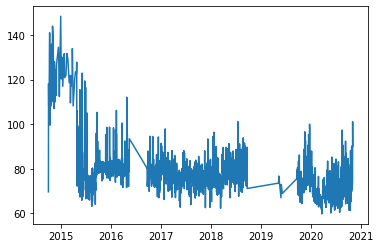

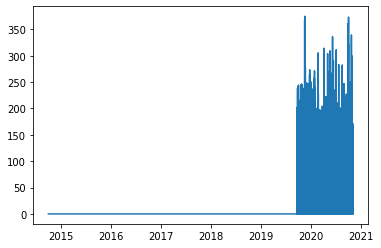

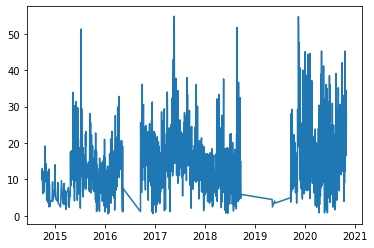

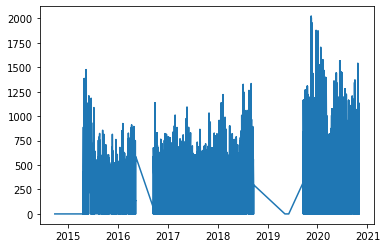

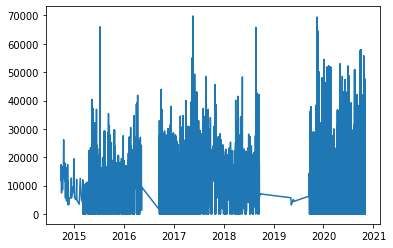

In [74]:
plt.plot('date','heartRate(BPM)Mean', data=health_df)
plt.show()
plt.plot('date','standTime(min)Sum', data=health_df)
plt.show()
plt.plot('date','walkingRunningDistance(km)Sum', data=health_df)
plt.show()
plt.plot('date','activeEnergyBurned(kal)Sum', data=health_df)
plt.show()
plt.plot('date','stepCountSum', data=health_df)
plt.show()

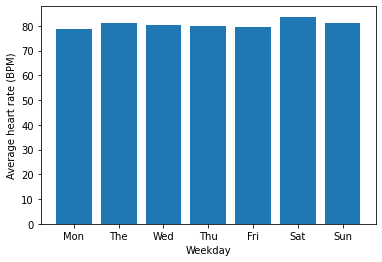

In [76]:
data = pd.DataFrame(health_df.groupby(['weekday'])['heartRate(BPM)Mean'].mean())
data = data['heartRate(BPM)Mean']
labels = data.index

plt.xticks(labels, ['Mon', 'The', 'Wed', 'Thu','Fri', 'Sat', 'Sun'])
plt.xlabel('Weekday')
plt.ylabel('Average heart rate (BPM)')
plt.bar(labels, data)
plt.show()

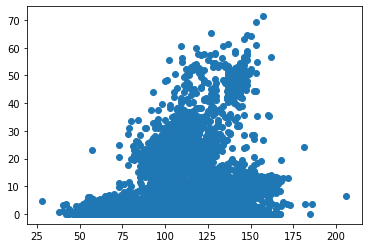

In [78]:
plt.scatter('heartRate(BPM)','activeEnergyBurned(kal)', data=health_df,)

plt.show()